In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from torch.utils.data import DataLoader
from time import time
import random
import json
import argparse

from data_loader import SeqDataLoader
from models.my_model import SE_CNN_LSTM
from models.lstm import LSTMPredictor
from models.lstm_ae import LSTMAutoencoder


In [2]:
def set_global_seed(seed=42):
    # 设置 Python 的随机种子
    random.seed(seed)
    # 设置 NumPy 的随机种子
    np.random.seed(seed)
    # 设置 PyTorch 的 CPU 随机种子
    torch.manual_seed(seed)
    # 设置 PyTorch 的 CUDA 随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # 禁用 CUDA 卷积操作的非确定性算法
        torch.backends.cudnn.deterministic = True
        # 禁用 CUDA 卷积操作的自动寻找最优算法
        torch.backends.cudnn.benchmark = False

set_global_seed()

In [33]:

# config_path = './run_swat.json'
# if not os.path.exists(config_path):
#     raise FileNotFoundError(f"Config file not found: {config_path}")
# if not os.pat.exists('./checkpoints'):
#     os.makedirs('./checkpoints')
# with open(config_path, 'r') as f:
#     config = json.load(f)
config = {
    "dataset_args": {
        "dataset": "swat",
        "train_data_path": "./dataset/swat/train.csv",
        "test_data_path": "./dataset/swat/test.csv",
        "winsize": 60,
        "step": 20
    },
    "model_args": {
        "model": 0,
        "input_dim": 51,
        "cnn1": 64,
        "k1": 5,
        "pad1": 2,
        "SEratio1": 8,
        "maxpool1": 2,
        "cnn2": 128,
        "k2": 3,
        "pad2": 1,
        "maxpool2": 2,
        "SEratio2": 16,
        "hidden_dim": 64,
        "lstm_layers": 4
    },
    "training_args": {
        "model_dir": None,
        "lr": 0.01,
        "epochs": 20,
        "batch_size": 32,
        "AE_MODEL": False,
        "threshold": 0.5
    }
}

dataset_args = config["dataset_args"]
model_args = config["model_args"]
training_args = config["training_args"]

AE_MODEL = training_args["AE_MODEL"]   # 是否是自编码器模型

# 检测是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [21]:

"""数据加载"""
dataset_name = dataset_args["dataset"]
train_data = SeqDataLoader(dataset_path=dataset_args["train_data_path"], win_size=dataset_args["winsize"], step=dataset_args["step"], name=f"{dataset_name} Train")
print(f'Train data length: {len(train_data)}')
print('Data sample shape:', train_data[0][0].shape)

"""数据加载"""
dataset_name = dataset_args["dataset"]
test_data = SeqDataLoader(dataset_path=dataset_args["test_data_path"], win_size=dataset_args["winsize"], step=1, name=f"{dataset_name} Test")
y_true = test_data.get_test_labels()
print(f'Test data length {len(test_data)}')
print(f'Test set Normal : {np.sum(y_true == 0)}; Attack : {np.sum(y_true == 1)}')
print('Data sample shape:', test_data[0][0].shape)
y_true_1 = np.where(y_true==1)[0]
print(len(y_true_1))

Loading swat Train data, window size is 60, step is 20
swat Train data shape: (495000, 51)
Train data length: 24747
Data sample shape: (60, 51)
Loading swat Test data, window size is 60, step is 1
swat Test data shape: (449919, 51)
Test data length 449859
Test set Normal : 395298; Attack : 54621
Data sample shape: (60, 51)
54621


In [ ]:

"""模型创建"""
data_dim = train_data[0][0].shape[-1]
model_list = [SE_CNN_LSTM, LSTMPredictor, LSTMAutoencoder]
model = model_list[model_args["model"]](model_args)  # 选择模型

model.to(device)  # 将模型移动到GPU上

filenameWithoutExt = f'{model.ModelName}_{dataset_args["dataset"]}_{int(time())}'

"""模型训练"""
learning_rate = training_args["lr"]
num_epochs = training_args["epochs"]
batch_size = training_args["batch_size"]
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# 训练循环，显示进度条
losses = []
model.train()
for epoch in tqdm(range(num_epochs)):
    for i, (x, x_1) in enumerate(data_loader):
        optimizer.zero_grad()
        x = x.to(device)  # 将数据移动到GPU上
        x_1 = x_1.to(device)  # 将数据移动到GPU上
        y = model(x)
        if AE_MODEL:
            loss = criterion(y[:,-1,:], x[:,-1,:])  # 自编码器的目标是重构，用窗口内的最后一步比较误差
        else:
            loss = criterion(y, x_1)  # 下一步的数据作为预测目标
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if i % 500 == 0:
            print(f'Epoch {epoch}, batch {i}, loss: {loss.item()}')
# 保存模型
torch.save(model.state_dict(), f"./checkpoints/{filenameWithoutExt}.pth")
config["training_args"]["model_dir"] = f"./checkpoints/{filenameWithoutExt}.pth"
print(f"Model saved to ./checkpoints/{filenameWithoutExt}.pth")
# 绘图
plt.plot(losses, label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


"""结果保存"""
# 保存超参数结果到json文件
with open(f'./checkpoints/{filenameWithoutExt}.json', 'w') as f:
    json.dump({'args': config}, f, indent=4)
    print(f"Config saved to ./checkpoints/{filenameWithoutExt}.json")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, batch 0, loss: 0.47727319598197937
Epoch 0, batch 500, loss: 0.5282800197601318


  5%|▌         | 1/20 [00:15<05:02, 15.93s/it]

Epoch 1, batch 0, loss: 0.3072633445262909
Epoch 1, batch 500, loss: 0.531277060508728


 10%|█         | 2/20 [00:32<04:55, 16.40s/it]

Epoch 2, batch 0, loss: 0.23007692396640778
Epoch 2, batch 500, loss: 0.24347636103630066


 15%|█▌        | 3/20 [01:00<06:10, 21.82s/it]

Epoch 3, batch 0, loss: 0.2507707178592682
Epoch 3, batch 500, loss: 0.29801487922668457


 20%|██        | 4/20 [01:44<08:03, 30.24s/it]

Epoch 4, batch 0, loss: 0.38097453117370605
Epoch 4, batch 500, loss: 0.2589585483074188


 25%|██▌       | 5/20 [02:28<08:52, 35.53s/it]

Epoch 5, batch 0, loss: 0.315965473651886
Epoch 5, batch 500, loss: 0.3246470093727112


 30%|███       | 6/20 [03:10<08:44, 37.47s/it]

Epoch 6, batch 0, loss: 1.0076801776885986


100%|██████████| 774/774 [00:33<00:00, 23.09it/s]


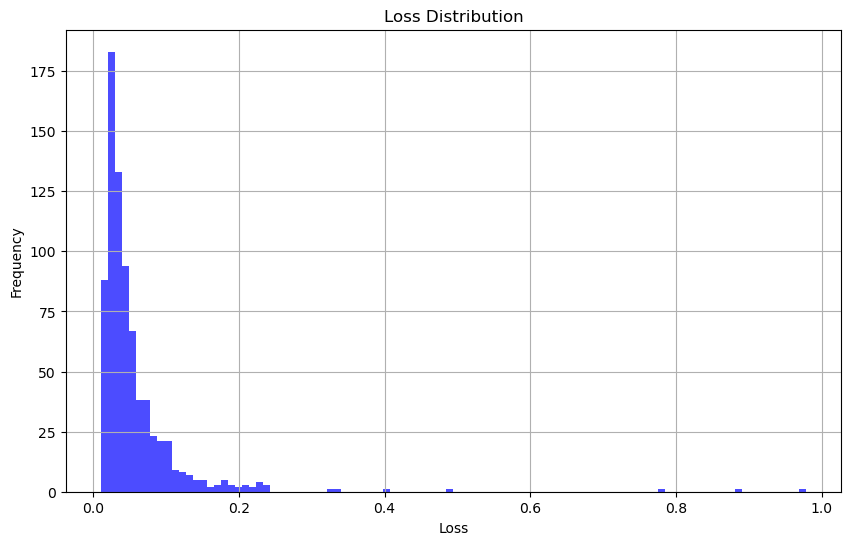

In [28]:
model.eval()
losses4train = []
with torch.no_grad():
    for x, x_1 in tqdm(data_loader):
        x = x.to(device)
        x_1 = x_1.to(device)
        y = model(x)
        if AE_MODEL:
            loss = criterion(y[:,-1,:], x[:,-1,:])     # 自编码器的目标是重构，用窗口内的最后一步比较误差
        else:
            loss = criterion(y, x_1)     # 下一步的数据作为预测目标

        losses4train.append(loss.item())

# 绘制误差数值分布，以便选择阈值
plt.figure(figsize=(10, 6))
plt.hist(losses4train, bins=100, color='blue', alpha=0.7)
plt.title('Loss Distribution')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.grid()
plt.savefig(f"./checkpoints/{filenameWithoutExt}_loss_distribution.png")
plt.show()


100%|██████████| 7030/7030 [09:40<00:00, 12.11it/s]


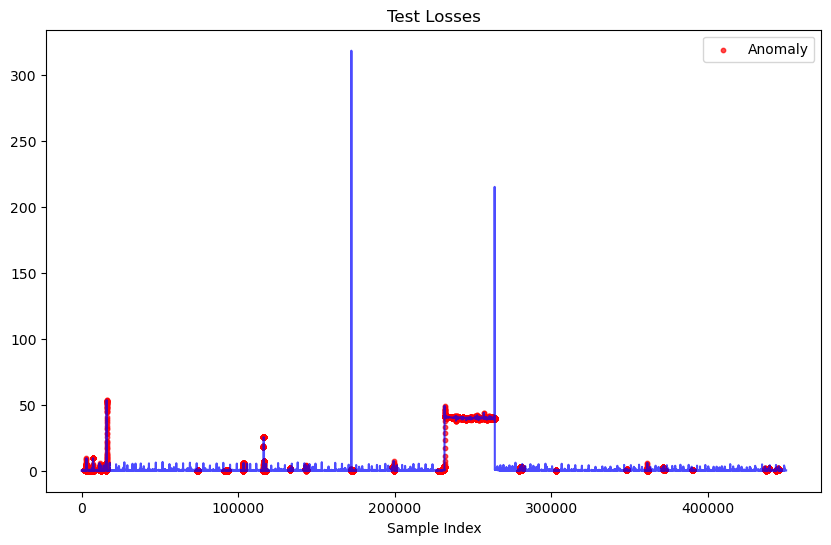

In [29]:

"""模型评估"""
test_losses = []
criterion = nn.MSELoss(reduction='none')
test_data_loader = DataLoader(test_data, batch_size=64, shuffle=False)  # 评估所用batch_size不影响
with torch.no_grad():
    for x, x_1 in tqdm(test_data_loader):
        x = x.to(device)
        x_1 = x_1.to(device)
        y = model(x)
        if AE_MODEL:
            loss = criterion(y[:,-1,:], x[:,-1,:]).mean(dim=1)     # 自编码器的目标是重构，用窗口内的最后一步比较误差
        else:
            loss = criterion(y, x_1).mean(dim=1)     # 下一步的数据作为预测目标

        test_losses += loss.tolist()

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(test_losses, color='blue', alpha=0.7)
plt.scatter(y_true_1, np.array(test_losses)[y_true_1], color='red', label='Anomaly', alpha=0.7, s=10)
plt.title('Test Losses')
plt.xlabel('Sample Index')
plt.legend()



In [30]:
config["training_args"]["threshold"] = 0.4
text = []
thresholds = np.percentile(test_losses, [80, 85, 90, 95, 99]).tolist()
thresholds += [config["training_args"]["threshold"]]  

for threshold in thresholds:
    y_pred = (np.array(test_losses) > threshold).astype(int)
    if AE_MODEL:    
        y_pred = np.concatenate([np.zeros(dataset_args["winsize"]-1), y_pred]) # 自编码器的预测是窗口内的最后一步
        y_pred = np.concatenate([y_pred, np.zeros(1)])     # 由于数据集构造是面向预测的，最后一步不在训练集里面
    else:
        y_pred = np.concatenate([np.zeros(dataset_args["winsize"]), y_pred])  # 预测下一步
    text.append(f'threshold: {threshold}\n' + classification_report(y_true, y_pred, target_names=['Normal', 'Attack']) + '\n')
    print(text[-1])

"""结果保存"""
# 保存评估结果到json文件
with open(f'./checkpoints/{filenameWithoutExt}.json', 'w') as f:
    json.dump({'args': config, 'classification_report': text}, f, indent=4)

threshold: 0.3504990041255951
              precision    recall  f1-score   support

      Normal       0.97      0.88      0.92    395298
      Attack       0.49      0.80      0.61     54621

    accuracy                           0.87    449919
   macro avg       0.73      0.84      0.77    449919
weighted avg       0.91      0.87      0.89    449919


threshold: 0.48586792647838584
              precision    recall  f1-score   support

      Normal       0.97      0.94      0.95    395298
      Attack       0.62      0.77      0.69     54621

    accuracy                           0.92    449919
   macro avg       0.80      0.85      0.82    449919
weighted avg       0.93      0.92      0.92    449919


threshold: 0.9087589025497456
              precision    recall  f1-score   support

      Normal       0.96      0.99      0.97    395298
      Attack       0.88      0.72      0.79     54621

    accuracy                           0.95    449919
   macro avg       0.92      0.85  